In [1]:
# !pip install pyomo==5.6.1

In [2]:
# !pip install jupyterthemes

In [3]:
# !pip install ipywidgets

In [4]:
# !wget -N -q https://ampl.com/dl/open/ipopt/ipopt-linux64.zip -P ~/Downloads/ --no-check-certificate

In [5]:
# !unzip -o -q ~/Downloads/ipopt-linux64.zip -d ~/Downloads/ipopt_solver/ \
# && mv ~/Downloads/ipopt_solver/ipopt ~/Downloads/ipopt_solver/ipopt_solver_executable

In [6]:
import matplotlib.pyplot as plt
import pyomo.environ as pye  # pyomo==5.6.1
import pyomo.dae as pyd
import numpy as np
import time

ipopt_executable = '~/Downloads/ipopt_solver/ipopt_solver_executable'

In [7]:
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
rc('animation', html='jshtml')

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

from ipywidgets import IntProgress
from IPython.display import display

## Parameters

In [8]:
# Rocket parameters
m_fuel = 1000000/5                # kg (liquid methane)
m_dry = 120000                    # kg (rocket body + payload)
m_total = m_dry + m_fuel

# Size
length = 50                       # m
width = 9                         # m

# Descent engine characteristics (only 3 engines have been seen working so far)
v_exhaust = 3*3280                # m/s exhaust velocity at sea level. 3 sea level + 3 vacuum engines. 3750 at vacuum
u_max = 3*2300000/v_exhaust       # 701 kg/s. One Raptor thrust is 2.3 MN

# Landing mission specifications
h_initial = 5000                  # m entry height
v_initial = 0                     # m/s entry speed
g = 9.81                          # m/s**2

# Inertia for a uniform density rod 
I = (1/12) * m_total * length**2

# Torque from engines thrust vestoring 
deg_to_rad = 0.01745329           # np.pi/180
max_deflection = 20 * deg_to_rad  # thrust vectoring +-20°
min_deflection = -max_deflection
max_torque = u_max * v_exhaust * length/2 * np.sin(max_deflection)
min_torque = -u_max *v_exhaust * length/2 * np.sin(max_deflection)

In [9]:
def solve(m):
    discretizer = pye.TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m, nfe=150, method='backward') 
    solver = pye.SolverFactory('ipopt', executable=ipopt_executable)
    
    # https://www.coin-or.org/Bonmin/option_pages/options_list_ipopt.html
    # https://coin-or.github.io/Ipopt/OPTIONS.html
    solver.options['max_iter']= 10000    # 3000 default
    solver.options['max_cpu_time'] = 2*60
    solver.options['tol'] = 1E-4
    st_ts = time.time()
    solver.solve(m)   # tee=True - prints logs, timelimit=60
    print(f'Solver time {round(time.time() - st_ts,3)} seconds')
    print(f'Objective value {round(m.obj(),3)}')

In [10]:
def plot(m):
    tsim = [t*m.T() for t in m.t]
    ysim = [m.y[t]() for t in m.t]
    vsim = [m.vy[t]() for t in m.t]
    fuel_sim = [m.u[t]() for t in m.t]
    thrust_angle_sim = [m.thrust_angle[t]() for t in m.t]
    fsim = [m.m[t]() - m_dry for t in m.t]
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,7))
    ax1.ticklabel_format(axis='y', style='plain')
    ax1.plot(tsim, ysim)
    ax1.set_title('Altitude')
    ax1.set_ylabel('meters')
    ax1.legend(['mission length = ' + str(round(m.T(),1)) + ' seconds'])
    
    ax2.plot(tsim, vsim)
    ax2.set_title('Vertical velocity')
    ax2.set_ylabel('m/sec')
    ax2.ticklabel_format(axis='y', style='plain')
    
    ax3.plot(tsim, fuel_sim/np.max(fuel_sim), color='royalblue', label='mass flow %')
    ax3.plot(tsim, thrust_angle_sim, color='royalblue', linestyle='--', label='thrust angle °')
    ax3.set_title('Engine mass flow & Thrust angle')
    ax3.legend(loc='best')
    # ax3.set_ylabel('kg/sec')
    
    ax4.plot(tsim, fsim)
    ax4.set_title('Fuel remaining')
    ax4.set_xlabel('time [seconds]')
    ax4.set_ylabel('kg')
    ax4.legend(['Fuel burned = ' + str(round(m.fuel(),1)) + ' kg'])
    ax4.ticklabel_format(axis='y', style='plain')
    
    plt.tight_layout()

## Solve model

Solver time 8.647 seconds
Objective value 15975.958


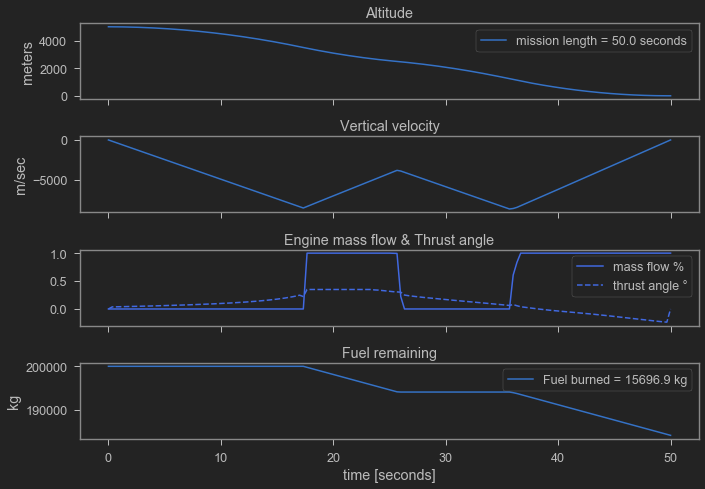

In [11]:
# Variables
m = pye.ConcreteModel()                             # Initialize model
m.t = pyd.ContinuousSet(bounds=(0,1))               # scaled time
m.x = pye.Var(m.t)                                  # x [m]
m.y = pye.Var(m.t, domain=pye.NonNegativeReals)     # y [m]
m.theta = pye.Var(m.t, bounds=(-2*np.pi,2*np.pi))   # angle of rotation along rocket centre [radian]
m.m = pye.Var(m.t, bounds=(m_dry, m_total))         # rocket mass (dry + fuel) [kg]
m.u = pye.Var(m.t, bounds=(0,u_max))                # engine mass flow [kg/s]
m.thrust_angle = pye.Var(m.t, bounds=(min_deflection,max_deflection))   # thrust vectoring angle [radian]
m.torque = pye.Var(m.t, bounds=(min_torque,max_torque))                 # Torque from thrust vectoring [N*m]
m.T = pye.Var(bounds=(50,3000))                     # landing time [s]
m.slack = pye.Var(m.t, bounds=(-10000,10000))

m.vx = pyd.DerivativeVar(m.x, wrt=m.t)              # m/s horizontal velocity
m.vy = pyd.DerivativeVar(m.y, wrt=m.t)              # m/s vertical speed
m.vtheta = pyd.DerivativeVar(m.theta, wrt=m.t)      # radian/s angular velocity
m.ax = pyd.DerivativeVar(m.vx, wrt=m.t)             # m/s2 horizontal acceleration
m.ay = pyd.DerivativeVar(m.vy, wrt=m.t)             # m/s2 vetical acceleration
m.atheta = pyd.DerivativeVar(m.vtheta, wrt=m.t)     # radian/s2 angular acceleration
m.mdot = pyd.DerivativeVar(m.m, wrt=m.t)            # kg/s fuel consumption speed

# Variables must satisfy mechanical force equilibrium at each time step
m.F_x = pye.Constraint(m.t, rule = lambda m, t: \
            m.m[t]*m.ax[t]/m.T**2 == v_exhaust*m.u[t]*pye.sin(m.thrust_angle[t] + m.theta[t]))
m.F_y = pye.Constraint(m.t, rule = lambda m, t: \
            m.m[t]*m.ay[t]/m.T**2 == -m.m[t]*g + v_exhaust*m.u[t]*pye.cos(m.thrust_angle[t] + m.theta[t]))
m.v_y = pye.Constraint(m.t, rule = lambda m, t: m.vy[t] <= 0)

m.torque_constraint = pye.Constraint(m.t, rule = lambda m, t: \
                                     m.torque[t] == -0.5*length*v_exhaust*m.u[t]*pye.sin(m.thrust_angle[t]))

# Unfortunately solver brakes with this constraint for some reason. 
# This equation gives rocket correct rotational inertia from. 
# m.torque_atheta = pye.Constraint(m.t, rule = lambda m, t: \
#                                  m.atheta[t]*(1/12 * m.m[t] * length**2) - m.slack[t] == m.torque[t])

m.m_t = pye.Constraint(m.t, rule = lambda m, t: m.mdot[t]/m.T == -m.u[t])

# Objective function - minimize thrust, thrust angle, and rocket angular velocity
m.fuel = pyd.Integral(m.t, wrt=m.t, rule = lambda m, t: m.u[t]*m.T)
m.obj_expression = pyd.Integral(m.t, wrt=m.t, rule = lambda m, t: \
                                1*m.T*(m.u[t]) +\
                                0*m.T*(m.thrust_angle[t])**2 +\
                                1*m.T*(m.vtheta[t])**2)
# Coefficients inside integral are arbitrary
m.obj = pye.Objective(expr=m.obj_expression, sense=pye.minimize)

# Boundary conditions - play with them 
m.x[0].fix(-600)
m.vx[0].fix(-500)
m.y[0].fix(h_initial)
m.vy[0].fix(-v_initial)
m.theta[0].fix(-np.pi/2)
m.vtheta[0].fix(0)
m.m[0].fix(m_total)

m.x[1].fix(0)            # Land at desired spot
m.vx[1].fix(0)           # Soft landing
m.y[1].fix(0)            # Soft landing
m.vy[1].fix(0)           # Soft landing
# m.ay[1].fix(0)           # Soft landing
m.theta[1].fix(0)        # Land upright
m.vtheta[1].fix(0)       # Land upright
m.thrust_angle[1].fix(0) # Land upright

solve(m)
plot(m)

Generating Animation


IntProgress(value=0, max=152)

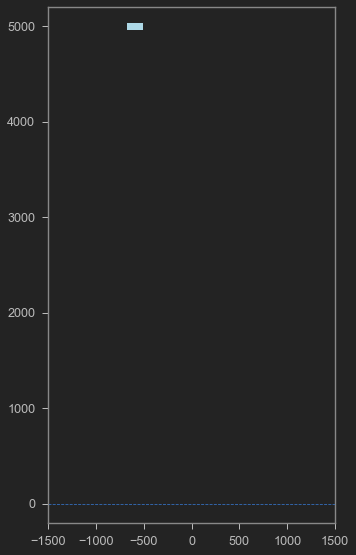

In [12]:
print("Generating Animation")
steps = len([t for t in m.t]) + 1
final_time_step = round(1/steps,2)
f = IntProgress(min = 0, max = steps)
display(f)

xsim = np.array([m.x[t]() for t in m.t]).reshape(-1,1)
vxsim = np.array([m.vx[t]() for t in m.t]).reshape(-1,1)
ysim = np.array([m.y[t]() for t in m.t]).reshape(-1,1)
vysim = np.array([m.vy[t]() for t in m.t]).reshape(-1,1)
theta_sim = np.array([m.theta[t]() for t in m.t]).reshape(-1,1)
vtheta_sim = np.array([m.vtheta[t]() for t in m.t]).reshape(-1,1)

thrust_sim = np.array([v_exhaust*m.u[t]() for t in m.t]).reshape(-1,1)
thrust_angle_sim = np.array([m.thrust_angle[t]() for t in m.t]).reshape(-1,1)

x_t = np.hstack([xsim,vxsim,ysim,vysim,theta_sim,vtheta_sim])
u_t = np.hstack([thrust_sim,thrust_angle_sim])

fig = plt.figure(figsize = (5,8), constrained_layout=False)
ax1 = fig.add_subplot(111)
plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
ln2, = ax1.plot([], [], linewidth = 2, color = 'tomato') # thrust line
ln1, = ax1.plot([], [], linewidth = 7, color = 'lightblue') # rocket body

plt.tight_layout()

ax1.set_xlim(-1500, 1500)
ax1.set_ylim(-200, 5200)
ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

def update(i):
    rocket_theta = x_t[i, 4]

    rocket_x = x_t[i, 0]
    # length/1 is just to make rocket bigger in animation
    rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

    rocket_y = x_t[i, 2]
    rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

    ln1.set_data(rocket_x_points, rocket_y_points)

    thrust_mag = u_t[i, 0]
    thrust_angle = -u_t[i, 1]

    flame_length = (thrust_mag) * (0.4/v_exhaust)
    flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
    flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]

    ln2.set_data(flame_x_points, flame_y_points)
    ln6.set_data(x_t[:i, 0], x_t[:i, 2])

    f.value += 1

playback_speed = 6500 # the higher the slower 
anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

anim

In [13]:
# anim.save('~/Downloads/rocket_landing.avi')